# Exploring `add_electricity.py` outputs

This jupyter notebook analyse the `add_electricity.py` **outputs**.

The `pypsa-earth/Snakefile` explicitly list in the **rule** what goes into the function `add_electricity.py` and what goes out (`elec.nc`). When inputs are commented out (#) than they are currently not considered. Maybe you want to make them run or develop new features? What can be observed from the inputs is that the script adds electrical generators, existing hydro storage, renewable generator profiles and loads units to a base network topology.

```
rule add_electricity:
    input:
        base_network='networks/base.nc',
        tech_costs=COSTS,
        regions="resources/regions_onshore.geojson",
        powerplants='resources/powerplants.csv',
        # hydro_capacities='data/bundle/hydro_capacities.csv',
        # geth_hydro_capacities='data/geth2015_hydro_capacities.csv',
        load='resources/ssp2-2.6/2030/era5_2013/Africa.nc',
        gadm_shapes='resources/gadm_shapes.geojson',
        **{f"profile_{tech}": f"resources/profile_{tech}.nc"
            for tech in config['renewable']}
    output: "networks/elec.nc"
    log: "logs/add_electricity.log"
    benchmark: "benchmarks/add_electricity"
    threads: 1
    resources: mem=3000
    script: "scripts/add_electricity.py"
```

Before analysing the outputs of add_electricity.py check that:
- `pypsa-earth` environment (/kernel) in jupyter notebook  is active and updated
- root folder where pypsa-earth is installed is named "pypsa-earth"
- or rename the below `sets_path_to_root("<folder_name>")` accordingly

In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('../../')) # To import helpers
if module_path not in sys.path:
    sys.path.append(module_path+"/pypsa-earth/scripts")
    
from _helpers import sets_path_to_root

sets_path_to_root("pypsa-earth-project")

This is the repository path:  /home/anas/EDF/pypsa-earth-project
Had to go 2 folder(s) up.


A jupyter notebook requires the user to import all they need. So we need to import all the required dependencies from the `pypsa-earth` environment:

In [2]:
import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd

# import geoviews as gv
# import hvplot.pandas
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib as plt

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

## Network analysis

Now let's import the output file which should be in i.e. `~/pypsa-earth/networks/elec.nc`. 

Note: If you don't have the /elec.nc file yet in your folder structure, you could try to generate it from the terminal. In this case set the path so that you are located at `~/pypsa-earth`. Once you are there, use the command:
```
snakemake -j 1 networks/elec.nc
```
Note that this is something you can to for any other rule to generate it's outputs `snakemake -j 1 <output of rule>`

In [3]:
network_path = os.getcwd() + "/pypsa-earth/networks/elec.nc"
n = pypsa.Network(network_path)
n

INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, loads, storage_units, transformers


PyPSA Network 'PyPSA-Eur'
Components:
 - Bus: 257
 - Carrier: 15
 - Generator: 87
 - Line: 245
 - Load: 227
 - StorageUnit: 3
 - Transformer: 30
Snapshots: 8760

You might be interested to see what's in the Network Common Data Form or NetCDF (.nc) file. To assess that we use **xarray**

In [4]:
import xarray as xr

path = os.getcwd() + "/pypsa-earth/networks/elec.nc"
network_data = xr.open_dataset(path)

network_data

<xarray.Dataset>
Dimensions:                               (snapshots: 8760,
                                           investment_periods: 0,
                                           transformers_i: 30, carriers_i: 15,
                                           generators_i: 87,
                                           generators_t_p_max_pu_i: 70,
                                           storage_units_i: 3, lines_i: 245,
                                           loads_i: 227, loads_t_p_set_i: 227,
                                           buses_i: 257)
Coordinates:
  * snapshots                             (snapshots) int64 0 1 2 ... 8758 8759
  * investment_periods                    (investment_periods) float64 
  * transformers_i                        (transformers_i) object 'transf_1_0...
  * carriers_i                            (carriers_i) object 'geothermal' .....
  * generators_i                          (generators_i) object 'C0' ... '16 ...
  * generators_t_p_max_pu_i               (generators_t_p_max_pu_i) object '0...
  * storage_units_i                       (storage_units_i) object '0 hydro' ...
  * lines_i                               (lines_i) object '564729320-1_0' .....
  * loads_i                               (loads_i) object '0' '1' ... '256'
  * loads_t_p_set_i                       (loads_t_p_set_i) object '0' ... '256'
  * buses_i                               (buses_i) object '0' '1' ... '256'
Data variables: (12/83)
    snapshots_snapshot                    (snapshots) datetime64[ns] ...
    snapshots_objective                   (snapshots) float64 ...
    snapshots_generators                  (snapshots) float64 ...
    snapshots_stores                      (snapshots) float64 ...
    investment_periods_objective          (investment_periods) float64 ...
    investment_periods_years              (investment_periods) float64 ...
    ...                                    ...
    buses_lat                             (buses_i) float64 ...
    buses_country                         (buses_i) object ...
    buses_substation_lv                   (buses_i) bool ...
    buses_x                               (buses_i) float64 ...
    buses_y                               (buses_i) float64 ...
    buses_substation_off                  (buses_i) bool ...
Attributes:
    network_name:           PyPSA-Eur
    network_pypsa_version:  0.20.1
    network_srid:           4326
    meta:                   {}

A quick check of the network topology:

(<matplotlib.collections.PatchCollection at 0x7f356c897130>,
 <matplotlib.collections.LineCollection at 0x7f356c7bf700>)

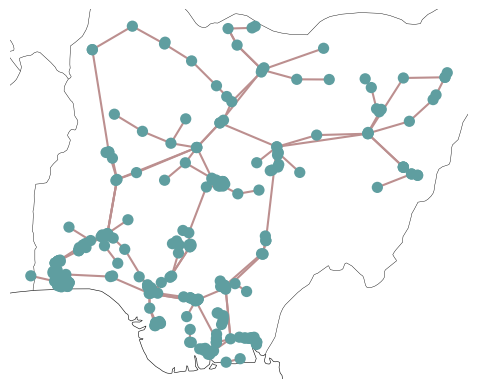

In [5]:
n.plot()

A full list of components are given: https://pypsa.readthedocs.io/en/latest/components.html#
We always check the PyPSA documentation to find analyse the components of interest.

In [6]:
n.buses.head(4)

,bus_id,v_nom,symbol,under_construction,tag_substation,tag_area,lon,lat,country,substation_lv,x,y,substation_off,type,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network
Bus,,,,,,,,,,,,,,,,,,,,,
0,0,220.0,substation,False,transmission,0.0,6.6507,5.0669,NG,True,6.6507,5.0669,True,,AC,None,1.0,0.0,inf,PQ,
1,1,220.0,substation,False,transmission,0.0,5.6343,6.2963,NG,True,5.6343,6.2963,True,,AC,None,1.0,0.0,inf,PQ,
2,2,300.0,substation,False,transmission,0.0,5.6353,6.2973,NG,False,5.6353,6.2973,True,,AC,None,1.0,0.0,inf,PQ,
3,3,300.0,substation,False,transmission,0.0,7.5578,6.4032,NG,True,7.5578,6.4032,True,,AC,None,1.0,0.0,inf,PQ,


In [7]:
n.lines.head(2)

,bus0,bus1,v_nom,num_parallel,length,underground,under_construction,tag_type,tag_frequency,country,geometry,bounds,bus_0_coors,bus_1_coors,bus0_lon,bus0_lat,bus1_lon,bus1_lat,type,s_max_pu,s_nom,capital_cost,x,r,g,b,s_nom_extendable,s_nom_min,s_nom_max,build_year,lifetime,carrier,terrain_factor,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Line,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
564729320-1_0,0,201,220.0,1.0,5.010445,False,False,line,50,NG,"LINESTRING (6.6507 5.0669, 6.650698800000018 5.066925700000043, 6....","MULTIPOINT (6.6507 5.0669, 6.6913 5.0619)",POINT (6.6507 5.0669),POINT (6.6913 5.0619),6.6507,5.0669,6.6913,5.0619,Al/St 240/40 2-bundle 220.0,0.7,491.556019,238.019025,0.0,0.0,0.0,0.0,False,0.0,inf,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
546624332-1_0,2,195,300.0,2.0,6.434654,False,False,line,50,NG,"LINESTRING (5.6353 6.2973, 5.6360829 6.2959648, 5.6394464 6.294203...","MULTIPOINT (5.6353 6.2973, 5.679 6.3064)",POINT (5.6353 6.2973),POINT (5.679 6.3064),5.6353,6.2973,5.6790,6.3064,Al/St 240/40 3-bundle 300.0,0.7,2010.910988,305.675486,0.0,0.0,0.0,0.0,False,0.0,inf,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# The maximal available power output
n.generators.groupby("carrier").p_nom_max.sum() / 1e3  # converted in [GW]

carrier
CCGT              inf
OCGT              NaN
oil               inf
onwind    1465.025709
solar     2509.665090
Name: p_nom_max, dtype: float64

In [9]:
# The (by the model) optimised installed power
n.generators.groupby("carrier").p_nom_opt.sum() / 1e3  # converted in [GW]

carrier
CCGT      0.0
OCGT      0.0
oil       0.0
onwind    0.0
solar     0.0
Name: p_nom_opt, dtype: float64

### Maximal available wind profile (as p.u.)

A time series is of the type of "series". See: https://pypsa.readthedocs.io/en/latest/components.html#generator
This requires to use `n.generator_t.p_max_pu` instead `n.generator.p_max_pu`

<AxesSubplot:xlabel='snapshot'>

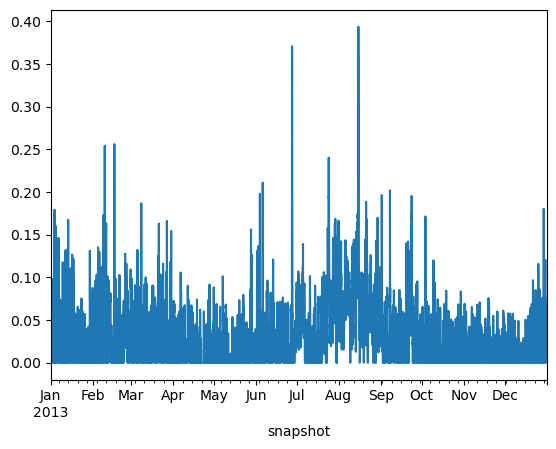

In [10]:
n.generators_t.p_max_pu.iloc[:, 0].plot()

# Load timeseries


<AxesSubplot:xlabel='snapshot'>

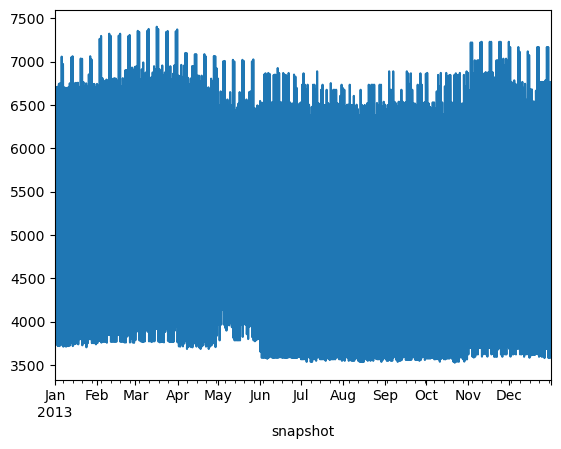

In [11]:
n.loads_t.p_set.sum(axis=1).plot()